
# 🧩 Compréhension du Problème

### Objectif :
 La ville de Seattle veut prédire la consommation énergétique
 totale des bâtiments non résidentiels pour réduire les émissions
 de carbone et atteindre la neutralité carbone d’ici 2050.

 La variable cible (target) est :
 SiteEnergyUse(kBtu) = consommation totale d’énergie d’un bâtiment

### Import des modules

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [31]:
# Charger les données
buildings = pd.read_csv("2016_Building_Energy_Benchmarking.csv")
buildings.head()

In [32]:
# On regarde comment un batiment est défini  dans ce jeu de données 
buildings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [33]:
print(f"Nombre de bâtiments : {buildings.shape[0]}")

Nombre de bâtiments : 3376


# 🔍 Analyse Exploratoire

In [34]:
# 1. Filtrer les bâtiments non résidentiels et les colonnes necessaires: 

building_consumption=buildings[
    buildings['BuildingType'] == 'NonResidential'].copy()

cols_to_keep = [
     'OSEBuildingID',
    'PrimaryPropertyType',    # Type précis du bâtiment (utile pour la consommation)
    'YearBuilt',              # Année de construction
    'PropertyGFATotal',       # Surface totale du bâtiment
    'SiteEnergyUseWN(kBtu)'     # Cible (target)
]

# Créer un nouveau dataframe avec ces colonnes
building_consumption = building_consumption[cols_to_keep].copy()
print("Colonnes conservées :", building_consumption.columns.tolist())
print(f"Nombre de bâtiments après filtrage NonResidential : {building_consumption.shape[0]}")

Colonnes conservées : ['OSEBuildingID', 'PrimaryPropertyType', 'YearBuilt', 'PropertyGFATotal', 'SiteEnergyUseWN(kBtu)']
Nombre de bâtiments après filtrage NonResidential : 1460


In [61]:
# Définition de la cible et des features importantes
target = "SiteEnergyUseWN(kBtu)"
features_num = ["PropertyGFATotal", "YearBuilt"]
features_cat = ["PrimaryPropertyType"]

In [48]:
### Statistiques descriptives pour les features numériques
print("\nStatistiques descriptives des features numériques :")
print(building_consumption[features_num].describe())


Statistiques descriptives des features numériques :
       PropertyGFATotal    YearBuilt
count      1.460000e+03  1460.000000
mean       1.130373e+05  1960.843836
std        1.923444e+05    32.966330
min        1.630000e+04  1900.000000
25%        2.916050e+04  1929.000000
50%        4.800350e+04  1965.000000
75%        1.041622e+05  1988.000000
max        1.952220e+06  2015.000000


In [49]:
### Statistiques descriptives pour les features numériques
print("\nStatistiques descriptives des features categorielles :")
print(building_consumption[features_cat].describe())


Statistiques descriptives des features categorielles :
                PrimaryPropertyType
count                          1460
unique                           21
top     Small- and Mid-Sized Office
freq                            288


## 2 🧹 Nettoyage des valeurs incohérentes

🎯 Objectif:

Les outliers sont des valeurs très éloignées du reste des données.
Elles ne sont pas forcément erronées, mais elles peuvent fausser les analyses statistiques et détériorer les performances du modèle.
L’objectif ici est donc de les identifier, puis éventuellement de les supprimer ou corriger selon leur impact.

### Détection des outliers par l’IQR (Interquartile Range)

cette méthode consiste à utiliser les quartiles :

Q1 : 25e percentile

Q3 : 75e percentile

IQR = Q3 − Q1
Toute valeur inférieure à Q1 − 1.5×IQR ou supérieure à Q3 + 1.5×IQR est considérée comme un outlier.


In [50]:
building_consumption.head()

,OSEBuildingID,PrimaryPropertyType,YearBuilt,PropertyGFATotal,SiteEnergyUseWN(kBtu)
0,1,Hotel,1927,88434,7456910.0
1,2,Hotel,1996,103566,8664479.0
2,3,Hotel,1969,956110,73937112.0
3,5,Hotel,1926,61320,6946800.5
4,8,Hotel,1980,175580,14656503.0


## 3. Visualisation avant nettoyage


In [51]:
# Sélection des colonnes numériques pertinentes
cols = ['SiteEnergyUseWN(kBtu)', 'PropertyGFATotal']

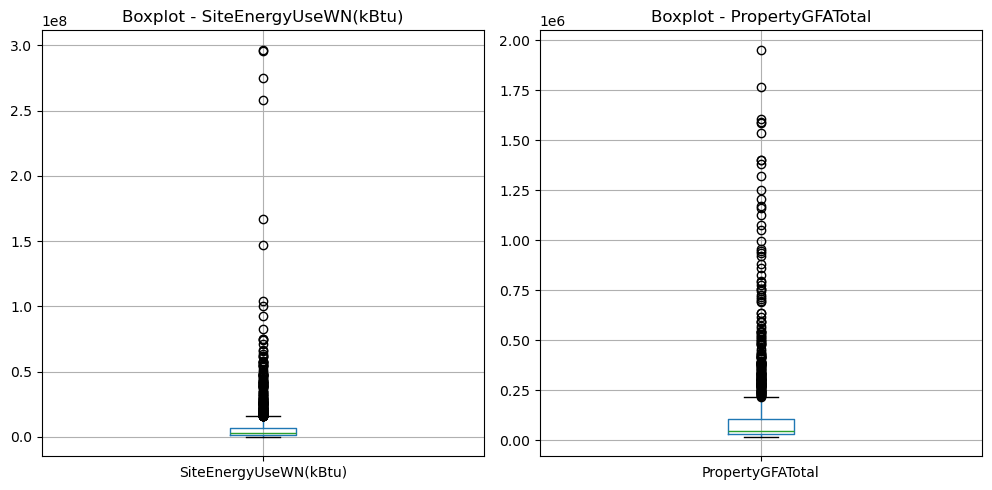

In [52]:
plt.figure(figsize=(15,5))
for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    building_consumption.boxplot(column=col)
    plt.title(f"Boxplot - {col}")
plt.tight_layout()
plt.show()

In [53]:
Q1 = building_consumption[cols].quantile(0.25)
Q3 = building_consumption[cols].quantile(0.75)
IQR = Q3 - Q1

# Détection des outliers
condition = ~((building_consumption[cols] < (Q1 - 1.5 * IQR)) | (building_consumption[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filtrage
building_consumption_model = building_consumption[condition]
print("Taille du dataset après suppression par IQR :", len(building_consumption_model))

Taille du dataset après suppression par IQR : 1235


## Visualisation aprés nettoayge

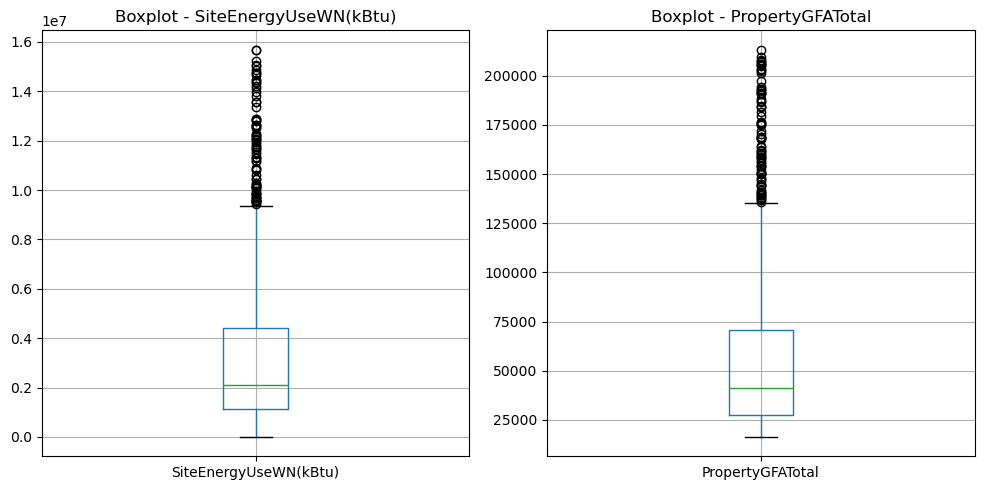

In [54]:
plt.figure(figsize=(15,5))
for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    building_consumption_model.boxplot(column=col)
    plt.title(f"Boxplot - {col}")
plt.tight_layout()
plt.show()

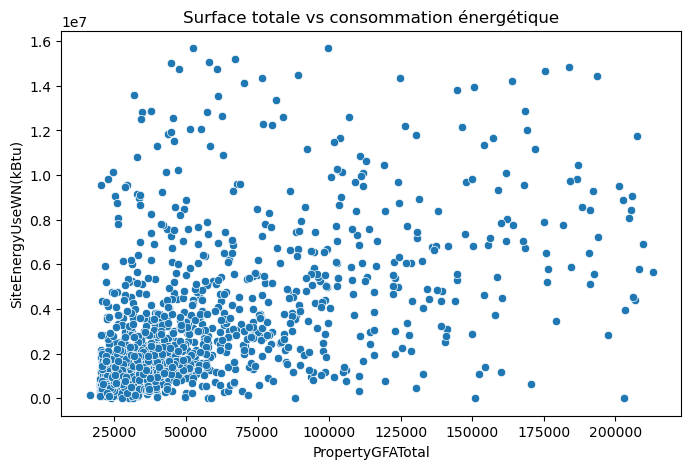

In [55]:
# Scatterplot : Surface totale vs consommation énergétique
plt.figure(figsize=(8,5))
sns.scatterplot(x="PropertyGFATotal", y=target, data=building_consumption_model)
plt.title("Surface totale vs consommation énergétique")
plt.xlabel("PropertyGFATotal")
plt.ylabel("SiteEnergyUseWN(kBtu)")
plt.show()

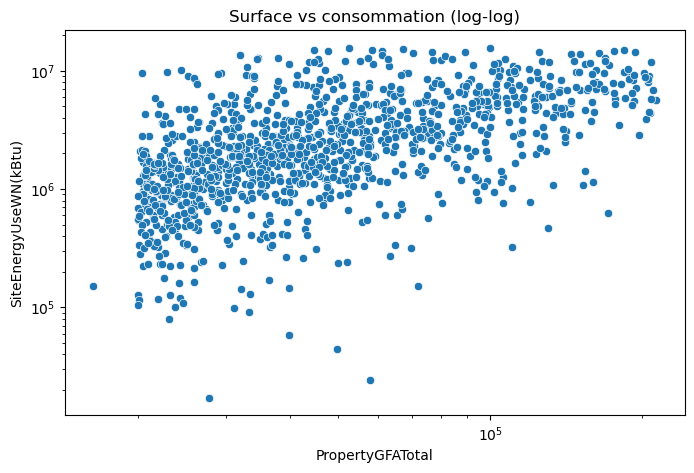

In [56]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="PropertyGFATotal", y=target, data=building_consumption_model)
plt.yscale("log")
plt.xscale("log")
plt.title("Surface vs consommation (log-log)")
plt.xlabel("PropertyGFATotal")
plt.ylabel("SiteEnergyUseWN(kBtu)")
plt.show()

### 📉 Relation entre la surface totale (`PropertyGFATotal`) et la consommation d’énergie (`SiteEnergyUseWN(kBtu)`)

#### ⚙️ Visualisation : Scatterplot (échelle logarithmique)
Le graphique représente la relation entre la surface totale du bâtiment et sa consommation d’énergie.  
Les deux axes sont en **échelle logarithmique (base 10)** afin de :
- mieux visualiser les petites et grandes valeurs sur un même graphique,  
- éviter que les très grands bâtiments « écrasent » le reste des données.

#### 📈 Interprétation :
- On observe une **corrélation positive** :  
  👉 plus la surface du bâtiment augmente, plus sa consommation énergétique tend à augmenter.
- Les points ne forment pas une droite parfaite :  
  cela indique que **d’autres facteurs influencent la consommation**, comme le type d’usage ou l’efficacité énergétique du bâtiment.
- Les **points isolés en haut à droite** correspondent à des bâtiments très grands et très énergivores (outliers).
- Les **points en bas à gauche** représentent les petits bâtiments à faible consommation.

#### 🧠 Conclusion :
> La surface du bâtiment est un **facteur clé** influençant la consommation d’énergie,  
> mais elle **n’explique pas à elle seule** toutes les différences : certains bâtiments consomment plus ou moins que la moyenne pour une même surface.

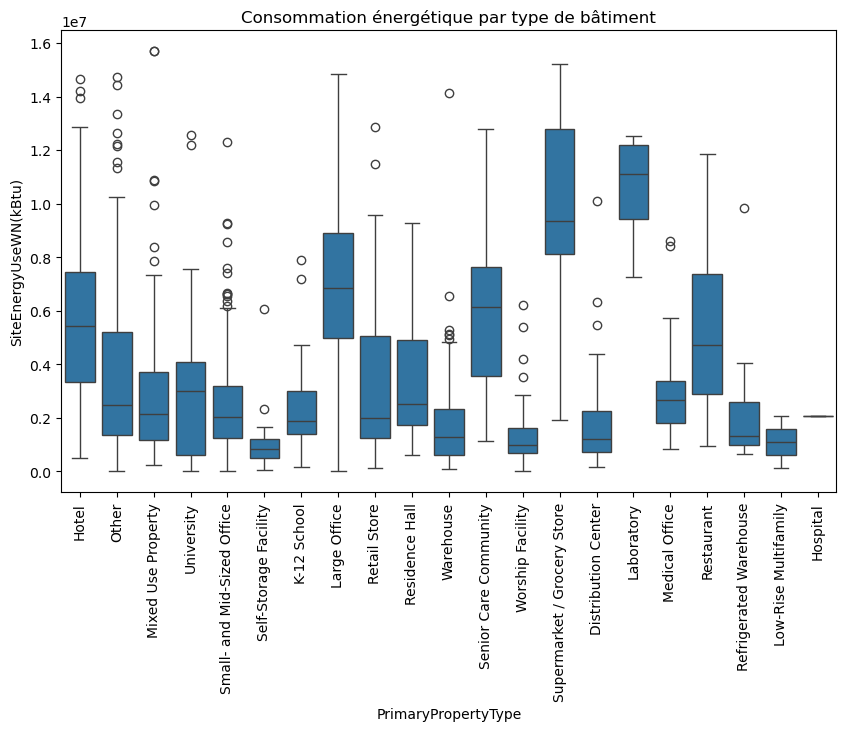

In [59]:
# Boxplot : Type de bâtiment vs consommation énergétique
plt.figure(figsize=(10,6))
sns.boxplot(x="PrimaryPropertyType", y=target, data=building_consumption_model)
plt.xticks(rotation=90)
plt.title("Consommation énergétique par type de bâtiment")
plt.xlabel("PrimaryPropertyType")
plt.ylabel("SiteEnergyUseWN(kBtu)")
plt.show()

### 📉Relation entre le type de bâtiment (PrimaryPropertyType) et la consommation d’énergie(SiteEnergyUseWN(kBtu))
⚙️ Visualisation : Boxplot (filtrage au quantile 0.95)

Le graphique représente la distribution de la consommation énergétique selon le type de bâtiment.
Le filtrage au quantile 0.95 permet de :

mieux visualiser la majorité des bâtiments,

limiter l’effet des valeurs extrêmes (outliers) sur la représentation.

### 📈 Interprétation :

Les hôpitaux (Hospital) présentent la consommation la plus élevée, avec plusieurs valeurs extrêmes.

Les universités (University) et les grands bureaux (Large Office) consomment également plus que la moyenne.

Les bâtiments résidentiels (Mid-Rise / Low-Rise Multifamily) consomment beaucoup moins.

Les points isolés (outliers) représentent des bâtiments atypiques très énergivores.

### 🧠 Conclusion :
Le type de bâtiment influence fortement la consommation énergétique.
Certains types, comme les bâtiments à usage intensif ou continu (hôpitaux, universités), consomment beaucoup plus que d’autres types, même pour des surfaces similaires.

## 💡Résumé EDA :

La surface totale a un impact significatif sur la consommation.

Le type de bâtiment est également un facteur clé.

Ces insights guideront le feature engineering et la sélection des variables pour les modèles de prédiction.

In [60]:
# Sauvegarde
building_consumption_model.to_parquet("mon_dataset.parquet", engine="pyarrow", index=False)